In [6]:
!pip install librosa
!rm -rf TIVlib
!git clone https://github.com/aframires/TIVlib.git
%cd TIVlib
!pip install soundfile

Cloning into 'TIVlib'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 216 (delta 73), reused 94 (delta 38), pack-reused 63 (from 1)
Receiving objects: 100% (216/216), 18.89 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/TIVlib/TIVlib


The following commented code is only necessary if you want to extract the features from the musc dataset again. If not, they are already extracted, and available in the repository, under `musical_features.csv`

In [ ]:
# import os
# from google.colab import drive
# import warnings
# warnings.filterwarnings('ignore')
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/Colab Notebooks/ # use this if you want to extract features from the folder with songs

In [ ]:
# if not os.path.exists("music_folder"):
#   print("Music data not found, extracting...")
#   !unzip archive.zip -d music_folder
# else:
#   print("Music data already extracted.")
# music_folder = '/content/drive/My Drive/Colab Notebooks/music_folder'
# music_folder

In [ ]:
# import random
# from IPython.display import Audio

# def select_random_file_from_subfolder(directory_path):
#     subfolders = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
#     if not subfolders:
#         return None
#     random_subfolder = random.choice(subfolders)
#     print(f"Selected subfolder: {random_subfolder}")
#     files = [f for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]
#     print(f"Files in selected subfolder: {files}")
#     return os.path.join(random_subfolder, random.choice(files))

# random_file = select_random_file_from_subfolder("music_folder/Data/genres_original/")
# print(random_file)
# Audio(random_file)

In [7]:
import os
import librosa
import numpy as np
import pandas as pd
from TIVlib import TIV as tiv

def load_and_clip_audio(file_path, clip_duration=30):
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        if duration > clip_duration:
            y = y[:clip_duration * sr]
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def extract_features(y, sr):
    try:
        # beat + tempo
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)

        # rhythm
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        beat_intervals = np.diff(beat_times) if len(beat_times) > 1 else [0]
        mean_beat_interval = np.mean(beat_intervals) if len(beat_intervals) > 0 else 0

        # harmonic + percussive
        harmonic, percussive = librosa.effects.hpss(y)

        # chroma / TIV
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        beat_chroma = librosa.util.sync(chroma_cqt, beat_frames, aggregate=np.mean)
        tiv_features = {"Chromaticity": [], "Diatonicity": [], "Dissonance": [], "Magnitude": []}
        for beat_index in range(beat_chroma.shape[1]):
            pcp_vector = beat_chroma[:, beat_index]
            tiv_profile = tiv.from_pcp(pcp_vector, data_type='audio')
            tiv_features["Chromaticity"].append(tiv.chromaticity(tiv_profile))
            tiv_features["Diatonicity"].append(tiv.diatonicity(tiv_profile))
            tiv_features["Dissonance"].append(tiv.dissonance(tiv_profile))
            tiv_features["Magnitude"].append(tiv.mags(tiv_profile))
        tiv_aggregated = {k: np.mean(v) for k, v in tiv_features.items()}

        # librosa
        librosa_features = {
            "Spectral Centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "Spectral Bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            "Spectral Rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            "RMS Energy": np.mean(librosa.feature.rms(y=y)),
            "Zero Crossing Rate": np.mean(librosa.feature.zero_crossing_rate(y)),
            "MFCC Mean": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "MFCC Variance": np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "Spectral Contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
            "Harmony Mean": np.mean(harmonic),
            "Harmony Variance": np.var(harmonic),
            "Percussive Mean": np.mean(percussive),
            "Percussive Variance": np.var(percussive),
            "Tempo": tempo,
            "Onset Strength Mean": np.mean(onset_env),
            "Onset Strength Variance": np.var(onset_env),
            "Mean Beat Interval": mean_beat_interval
        }

        return {**librosa_features, **tiv_aggregated}
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

ImportError: cannot import name 'TIV' from 'TIVlib' (unknown location)

In [ ]:
# def process_dataset(dataset_path, clip_duration=30, max_files=None):
#     data = []
#     file_count = 0

#     for folder, _, files in os.walk(dataset_path):
#         genre = os.path.basename(folder)
#         for file in files:
#             if file.endswith(('.wav', '.mp3')):
#                 file_path = os.path.join(folder, file)
#                 relative_path = os.path.relpath(file_path, dataset_path)
#                 print(f"Processing {relative_path}...")

#                 y, sr = load_and_clip_audio(file_path, clip_duration)
#                 if y is None or sr is None:
#                     continue

#                 features = extract_features(y, sr)
#                 if features is None:
#                     continue

#                 features.update({
#                     "File Name": relative_path,
#                     "Target": genre
#                 })
#                 data.append(features)
#                 file_count += 1

#                 if max_files is not None and file_count >= max_files:
#                     print(f"Reached maximum file limit: {max_files}")
#                     return pd.DataFrame(data)

#     return pd.DataFrame(data)

# final_df = process_dataset(music_folder)
# final_df.set_index('File Name', inplace=True)
# final_df.fillna(0, inplace=True)
# final_df.to_csv('musical_features.csv')

In [5]:
import os
import pandas as pd
if os.getcwd() == "/content/TIVlib":
  os.chdir("/content/")
if os.path.exists("musical_features.csv"):
  final_df = pd.read_csv('musical_features.csv')
  final_df.set_index('File Name', inplace=True)
  final_df.fillna(0, inplace=True)
  final_df["Tempo"] = final_df["Tempo"].apply(lambda x: float(x.strip('[]')))
final_df

,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,RMS Energy,Zero Crossing Rate,MFCC Mean,MFCC Variance,Spectral Contrast,Harmony Mean,Harmony Variance,...,Percussive Variance,Tempo,Onset Strength Mean,Onset Strength Variance,Mean Beat Interval,Chromaticity,Diatonicity,Dissonance,Magnitude,Target
File Name,,,,,,,,,,,,,,,,,,,,,
Data/genres_original/blues/blues.00015.wav,1420.411479,1730.917102,2930.240615,0.080639,0.063718,-4.253306,6240.9680,21.364321,-1.398105e-05,0.004730,...,0.002336,103.359375,1.460053,1.988041,0.604686,0.157652,0.061687,0.918362,0.766360,blues
Data/genres_original/blues/blues.00014.wav,1172.276301,1705.858377,2345.777482,0.066936,0.045046,-5.842912,9272.8510,21.617302,-1.175124e-04,0.004717,...,0.001200,151.999081,1.387912,2.054584,0.381615,0.191156,0.077172,0.893918,0.999138,blues
Data/genres_original/blues/blues.00016.wav,1455.042471,1825.909025,3009.965132,0.081419,0.061351,-3.659566,6137.8228,21.057216,-2.477557e-05,0.004509,...,0.002416,198.768029,1.406042,1.771489,0.301376,0.109594,0.070701,0.913721,0.802472,blues
Data/genres_original/blues/blues.00017.wav,1088.778116,1410.835953,2134.753758,0.093259,0.048324,-1.510453,7137.2295,21.719440,-1.125272e-05,0.006768,...,0.001524,172.265625,1.587924,3.025460,0.355014,0.128485,0.093376,0.890263,0.998963,blues
Data/genres_original/blues/blues.00013.wav,1324.331754,1827.384464,2710.366944,0.113189,0.051417,-1.767808,5141.6553,21.416027,-1.289524e-05,0.012688,...,0.001604,107.666016,1.376919,2.038245,0.560851,0.157062,0.079569,0.895618,1.000221,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Data/genres_original/rock/rock.00096.wav,2006.009248,2068.224879,4147.166589,0.076425,0.097659,-1.511460,3393.6875,22.669137,7.467836e-07,0.003983,...,0.000818,117.453835,1.085211,0.857461,0.512261,0.118948,0.232386,0.807903,1.766494,rock
Data/genres_original/rock/rock.00097.wav,2077.166788,1926.895810,4030.750627,0.081583,0.121824,-1.601387,3030.4124,22.317139,-9.287926e-08,0.003827,...,0.001124,129.199219,1.058164,0.715323,0.468893,0.091103,0.154549,0.878217,1.086236,rock
Data/genres_original/rock/rock.00095.wav,2008.537046,2106.349206,4254.124276,0.079441,0.089267,-1.013770,3521.4834,22.980343,2.329412e-06,0.004596,...,0.000681,103.359375,1.174831,1.467421,0.579551,0.124972,0.263404,0.793682,1.856938,rock


___
## Feature Analysis

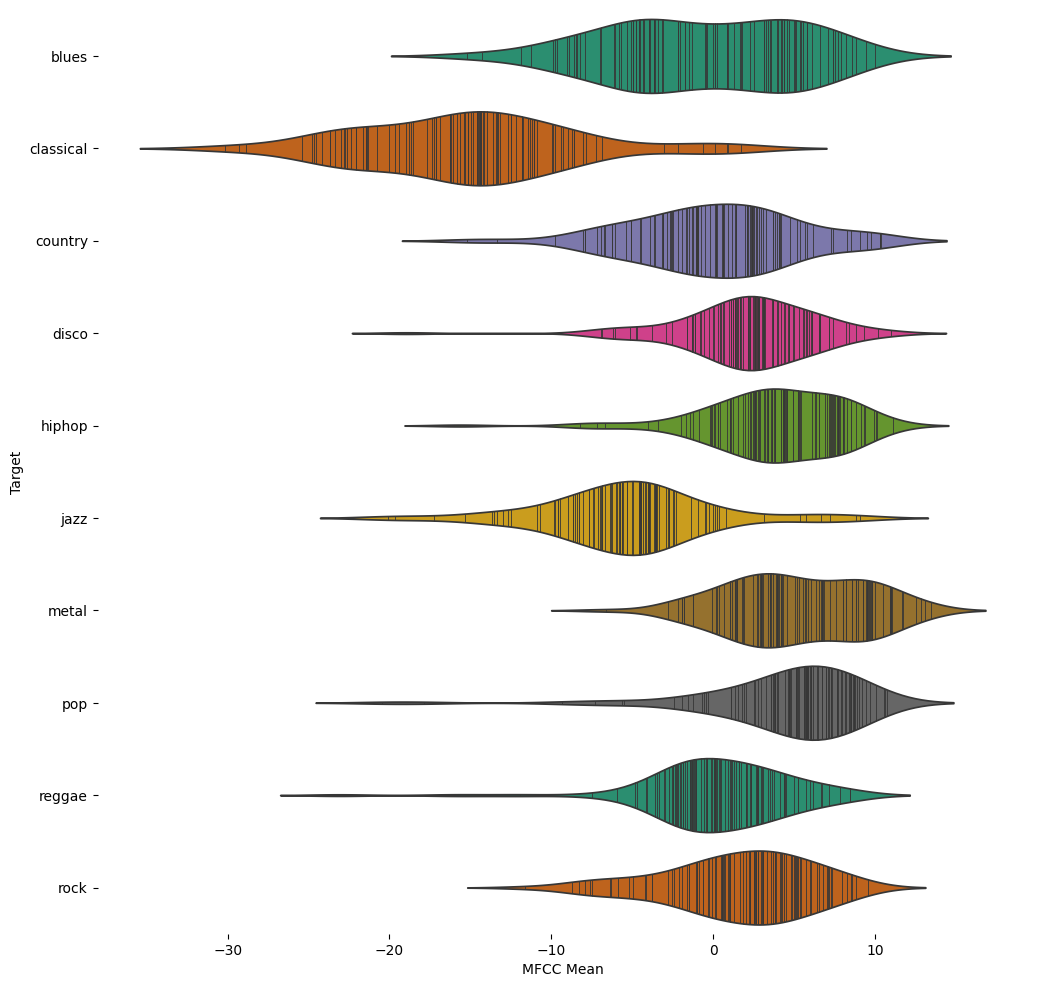

In [ ]:
# @title Target vs MFCC Mean

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='MFCC Mean', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

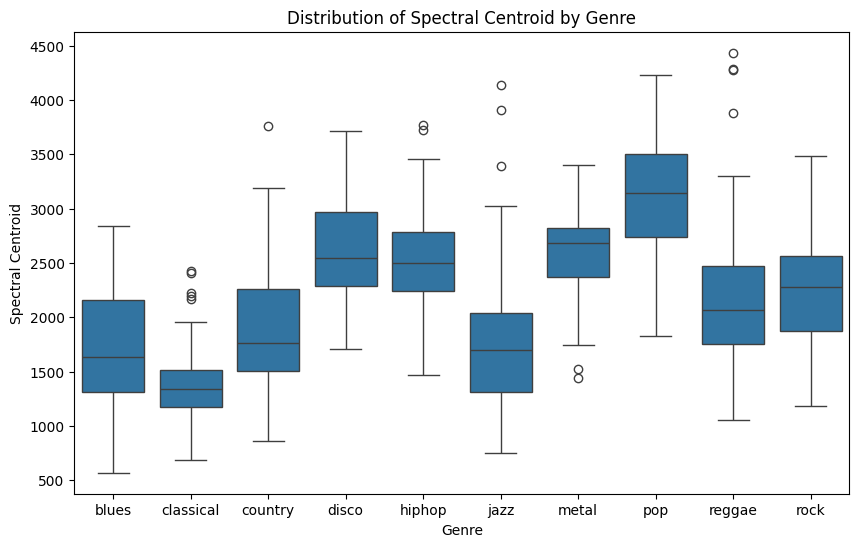

In [ ]:
# @title Distribution of Spectral Centroid by Genre

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Spectral Centroid', data=final_df)
plt.title('Distribution of Spectral Centroid by Genre')
plt.xlabel('Genre')
_ = plt.ylabel('Spectral Centroid')

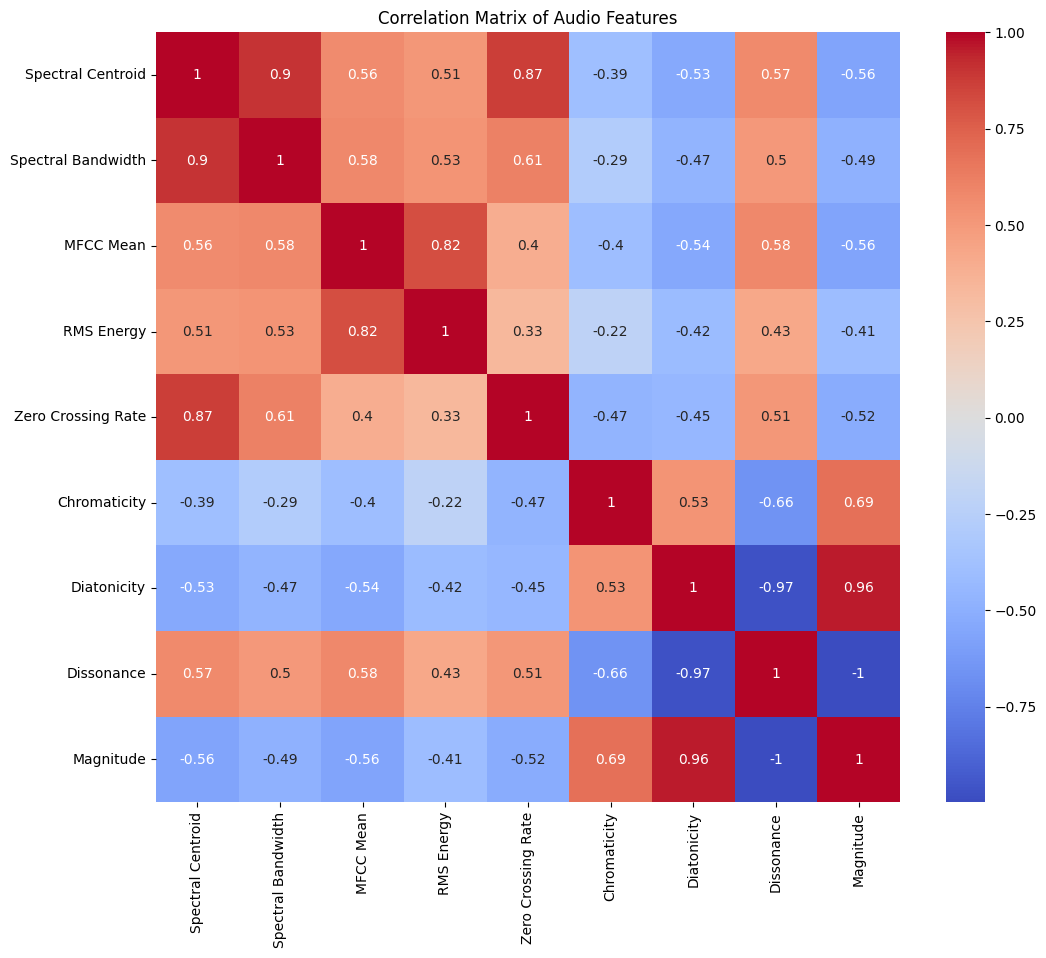

In [ ]:
# @title Correlation Matrix of Audio Features

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
num_features = ['Spectral Centroid', 'Spectral Bandwidth', 'MFCC Mean', 'RMS Energy', 'Zero Crossing Rate', 'Chromaticity', 'Diatonicity', 'Dissonance', 'Magnitude']
corr_matrix = final_df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
_ = plt.title('Correlation Matrix of Audio Features')

Feature Importance

In [6]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

X = final_df.drop(columns=['Target'])
y = final_df['Target']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

top_features = feature_importances.head(10)
print(top_features)

                   Feature  Importance
0      Onset Strength Mean    0.086223
1      Percussive Variance    0.070518
2  Onset Strength Variance    0.068307
3                MFCC Mean    0.065591
4       Spectral Bandwidth    0.060096
5        Spectral Contrast    0.054498
6              Diatonicity    0.052848
7               RMS Energy    0.051173
8            MFCC Variance    0.048801
9             Chromaticity    0.047919


In [7]:
from sklearn.feature_selection import mutual_info_classif

X = final_df.drop(columns=['Target'])
y = final_df['Target']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False).reset_index(drop=True)

top_features = mi_df.head(10)
print(top_features)

                   Feature  Mutual Information
0      Percussive Variance            0.528817
1      Onset Strength Mean            0.528015
2         Spectral Rolloff            0.448208
3        Spectral Centroid            0.427279
4       Spectral Bandwidth            0.423693
5            MFCC Variance            0.420933
6  Onset Strength Variance            0.389971
7                MFCC Mean            0.387053
8               Dissonance            0.385749
9               RMS Energy            0.384584


___
## Latent Clustering

Lets reduce the dimensionality of the data to 3D, and place the data points in the latent space, colored by genre.

### UMAP

In [8]:
!pip install umap-learn
import umap
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


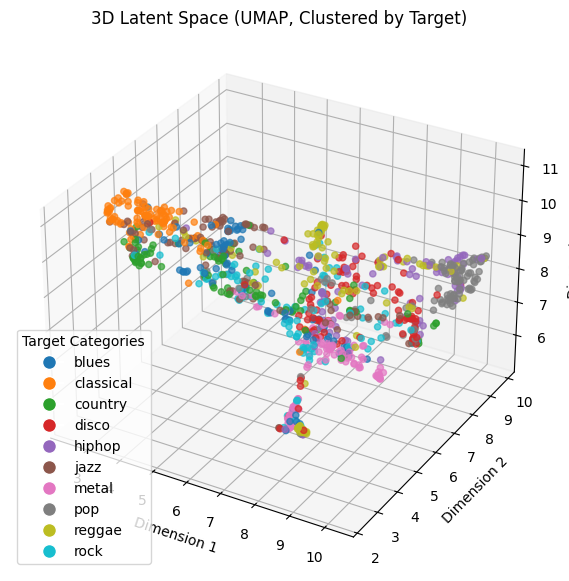

In [9]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(n_components=3, random_state=42)
latent_space = umap_reducer.fit_transform(normalized_data)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (UMAP, Clustered by Target)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

U-MAP seems reasonable at clustering the data points, so lets further improve it. Let's check which approach yields a better result: by employing supervised information, or by pre-clustering the data.

1. Using the target label as a supervised guide, and cluster-based parameters:

Silhouette Score: 0.7732453942298889


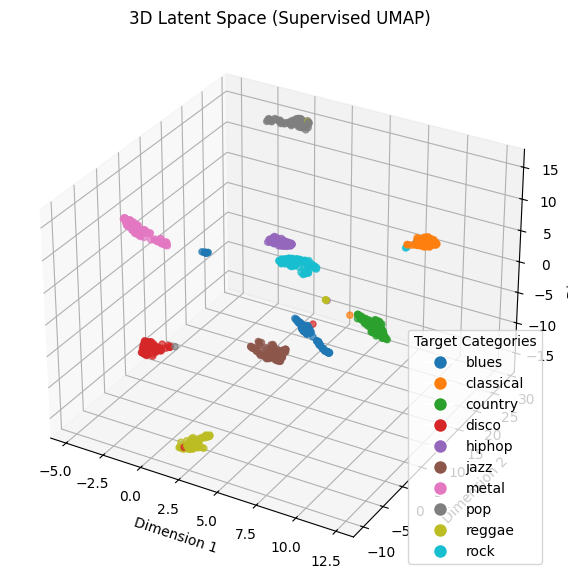

In [10]:
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

label_encoder = LabelEncoder()
encoded_targets = label_encoder.fit_transform(y)

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="euclidean",
    n_neighbors=45,
    min_dist=0.3,
    target_metric="categorical",
)
latent_space = umap_reducer.fit_transform(normalized_data, y=encoded_targets)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (Supervised UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

2. Pre-clustering:

Silhouette Score: -0.0526094064116478


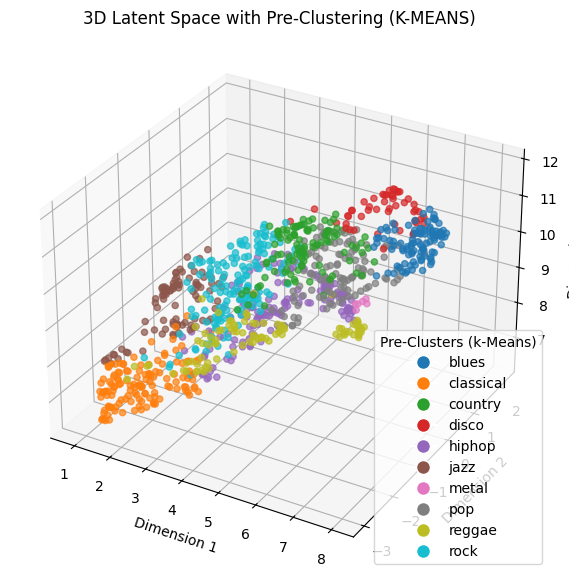

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

num_clusters = len(y.unique())
kmeans = KMeans(
        n_clusters=num_clusters,
        init="k-means++",
        random_state=42,
        n_init=10,)
cluster_labels = kmeans.fit_predict(normalized_data)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    n_neighbors=55,
    min_dist=0.2,
)
latent_space = umap_reducer.fit_transform(normalized_data)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (K-MEANS)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

___
### Optimization

As it can be seen, using supervised clustering is beneficial, as each cluster seems better defined and separable in this method. It also yelds a better (non-negative silhouette). K-Means shows more overlaps, but let's find out if it can be improved.
Now, lets use optuna to tune the parameters, and see if the same outcomes are reached.

[I 2024-12-30 15:16:36,643] A new study created in memory with name: no-name-0287fad6-8cde-4dc7-bb0d-c772bb26303c
[I 2024-12-30 15:16:48,729] Trial 0 finished with value: 0.7786390781402588 and parameters: {'n_neighbors': 35, 'min_dist': 0.18439559385698034, 'metric': 'euclidean'}. Best is trial 0 with value: 0.7786390781402588.
[I 2024-12-30 15:16:55,985] Trial 1 finished with value: 0.7427732944488525 and parameters: {'n_neighbors': 29, 'min_dist': 0.21657564356364967, 'metric': 'manhattan'}. Best is trial 0 with value: 0.7786390781402588.
[I 2024-12-30 15:17:00,701] Trial 2 finished with value: 0.43796971440315247 and parameters: {'n_neighbors': 15, 'min_dist': 0.26747191571471746, 'metric': 'cosine'}. Best is trial 0 with value: 0.7786390781402588.
[I 2024-12-30 15:17:02,887] Trial 3 finished with value: 0.2918170988559723 and parameters: {'n_neighbors': 11, 'min_dist': 0.2710484301643925, 'metric': 'cosine'}. Best is trial 0 with value: 0.7786390781402588.
[I 2024-12-30 15:17:04,9

Best parameters: {'n_neighbors': 42, 'min_dist': 0.015223687886775236, 'metric': 'manhattan'}
Best silhouette score: 0.8780823945999146


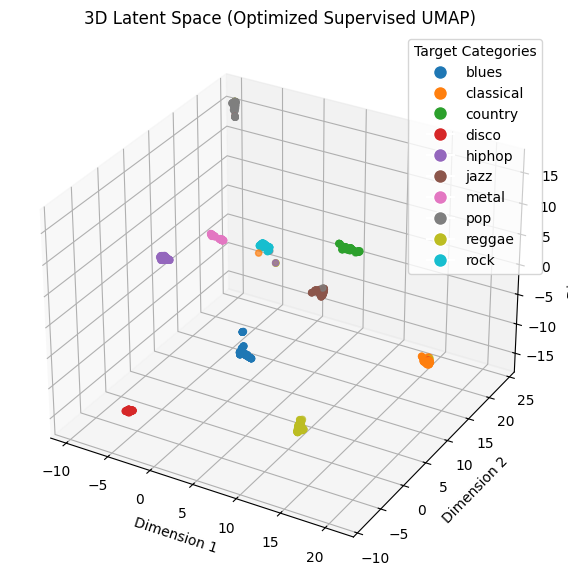

In [12]:
import optuna
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_float('min_dist', 0.0, 0.5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    n_components = 3

    umap_reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        target_metric='categorical',
        random_state=42
    )

    try:
        latent_space = umap_reducer.fit_transform(normalized_data, y=encoded_targets)
        score = silhouette_score(latent_space, encoded_targets)
        return score
    except Exception as e:
        return -1.0

study = optuna.create_study(direction='maximize')
n_trials = 20
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print('Best parameters:', best_params)
print('Best silhouette score:', study.best_value)

best_umap_s = umap.UMAP(
    **best_params,
    n_components=3,
    target_metric='categorical',
    random_state=42
)

s_latent_space = best_umap_s.fit_transform(normalized_data, y=encoded_targets)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    s_latent_space[:, 0],
    s_latent_space[:, 1],
    s_latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (Optimized Supervised UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

[I 2024-12-30 15:18:01,515] A new study created in memory with name: no-name-0e0e703d-8361-48d2-9221-bce031eab24a
[I 2024-12-30 15:18:04,366] Trial 0 finished with value: 0.3493632376194 and parameters: {'n_neighbors': 19, 'min_dist': 0.4920937069366213}. Best is trial 0 with value: 0.3493632376194.
[I 2024-12-30 15:18:08,070] Trial 1 finished with value: 0.4087412655353546 and parameters: {'n_neighbors': 19, 'min_dist': 0.17973550377894243}. Best is trial 1 with value: 0.4087412655353546.
[I 2024-12-30 15:18:13,183] Trial 2 finished with value: 0.3630014955997467 and parameters: {'n_neighbors': 48, 'min_dist': 0.342836613267209}. Best is trial 1 with value: 0.4087412655353546.
[I 2024-12-30 15:18:16,710] Trial 3 finished with value: 0.4138534367084503 and parameters: {'n_neighbors': 40, 'min_dist': 0.11400101598659301}. Best is trial 3 with value: 0.4138534367084503.
[I 2024-12-30 15:18:19,633] Trial 4 finished with value: 0.351148396730423 and parameters: {'n_neighbors': 20, 'min_dis

Best Silhouette Score: 0.5060985684394836
Best Parameters: {'n_neighbors': 5, 'min_dist': 0.007046891685436648}


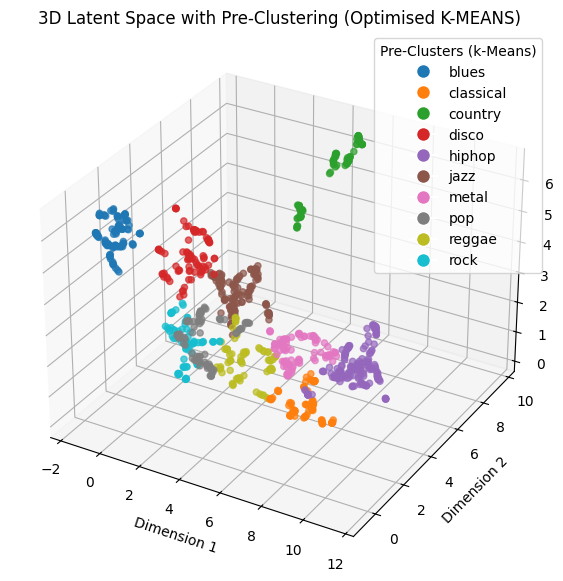

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 50)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.5)

    n_components = 3
    n_clusters = len(y.unique())

    try:
        umap_reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            random_state=42,
        )
        latent_space = umap_reducer.fit_transform(normalized_data)

        kmeans = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            random_state=42,
            n_init=10,
        )
        cluster_labels = kmeans.fit_predict(latent_space)

        score = silhouette_score(latent_space, cluster_labels)
        return score
    except Exception as e:
        return -1.0

study = optuna.create_study(direction="maximize")
n_trials = 20
study.optimize(objective, n_trials=n_trials)

print(f"Best Silhouette Score: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_parallel_coordinate(study)

best_umap_k = umap.UMAP(
    n_neighbors=study.best_params["n_neighbors"],
    min_dist=study.best_params["min_dist"],
    n_components=3,
    random_state=42,
)

best_kmeans = KMeans(
    n_clusters=len(y.unique()),
    init="k-means++",
    random_state=42,
    n_init=10,
)

k_latent_space = best_umap_k.fit_transform(normalized_data)
final_cluster_labels = best_kmeans.fit_predict(k_latent_space)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    k_latent_space[:, 0],
    k_latent_space[:, 1],
    k_latent_space[:, 2],
    c=final_cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (Optimised K-MEANS)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

The best approach is clearly using supervised clustering, as silhouette score is much higher, and by visually inspecting, clusters are overlapping each other in pre-clustering. However, this is on in-distribution data. Let's check external examples, with novel songs.

___
## Classify new Samples

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def project_and_analyze_new_song(file_path, umap_reducer, scaler, latent_space, targets, categories, is_supervised=True, k_neighbors=150):
    y, sr = load_and_clip_audio(file_path)
    features = extract_features(y, sr)
    if features is None:
        print("Failed to extract features from the new song.")
        return

    features_df = pd.DataFrame([features])
    scaled_features = scaler.transform(features_df)

    new_song_latent = umap_reducer.transform(scaled_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    if is_supervised:
        unique_targets = np.unique(targets)
        color_map = plt.cm.get_cmap('tab10', len(unique_targets))
        colors = [color_map(np.where(unique_targets == t)[0][0]) for t in targets]
    else:
        color_map = plt.cm.get_cmap('tab10', len(categories))
        colors = [color_map(t) for t in targets]  # targets are already cluster labels in k-means

    scatter = ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=colors, alpha=0.7)

    new_song_latent[0, 1] -= 0.5 # adjust position to make it more visible
    new_song_latent[0, 2] += 0.5 # adjust position to make it more visible
    new_song_plot = ax.scatter(new_song_latent[0, 0], new_song_latent[0, 1], new_song_latent[0, 2],
                               c='white', edgecolors='black', s=200, marker='*', zorder=10)


    legend_elements = [plt.Line2D([0], [0], marker="o", color='w', markerfacecolor=color_map(i),
                                  markersize=10, label=cat) for i, cat in enumerate(categories)]
    legend_elements.append(plt.Line2D([0], [0], marker="*", color='w', markerfacecolor='white',
                                      markeredgecolor='black', markersize=15, label='New Song'))

    ax.legend(handles=legend_elements, title="Categories", loc='best')

    ax.set_title(f"3D Latent Space {'(Supervised UMAP)' if is_supervised else '(UMAP with K-means)'}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.tight_layout()
    plt.show()

    distances = np.linalg.norm(latent_space - new_song_latent, axis=1)

    closest_indices = np.argsort(distances)[:k_neighbors]

    nearest_genres = [categories[targets[i]] for i in closest_indices]
    assigned_genre = pd.Series(nearest_genres).value_counts().index[0]

    report = f"\nNew Song Analysis:\n"
    report += f"Assigned Genre: {assigned_genre}\n"
    report += f"Genre Distribution (Top {k_neighbors} nearest):\n"
    for genre, count in pd.Series(nearest_genres).value_counts().items():
        report += f"  {genre}: {count}\n"
    report += f"\nFeatures:\n"
    for feature, value in features.items():
        if isinstance(value, np.ndarray):
            report += f"  {feature}: {value.mean():.4f} (mean)\n"
        else:
            report += f"  {feature}: {value:.4f}\n"

    print(report)
    return new_song_latent, features, assigned_genre, report


___
### Testing Inference:

Let's try to test both methods, with new songs, not used in defining the latent space. The distribution of these new samples is different, so their latent representation may be different.

___
metal

In [15]:
new_song_file = "metal.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

Error loading metal.mp3: [Errno 2] No such file or directory: 'metal.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.
Error loading metal.mp3: [Errno 2] No such file or directory: 'metal.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.


___
country

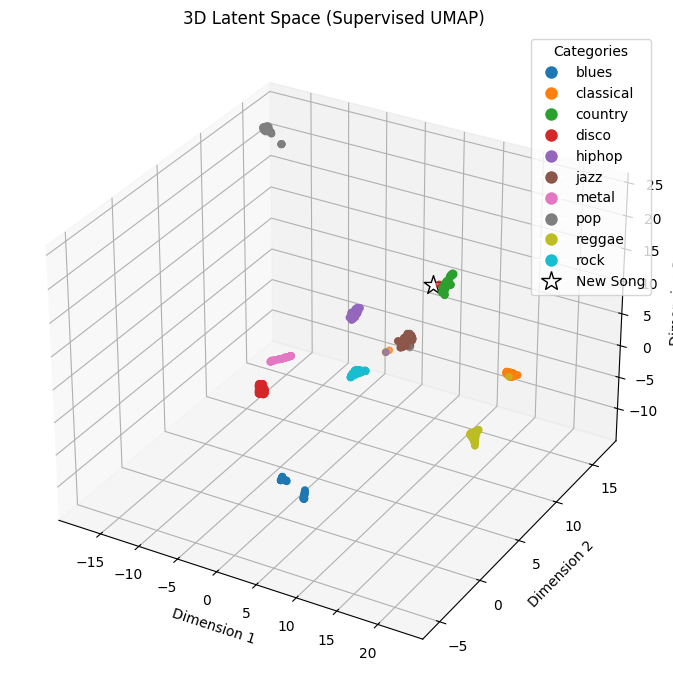


New Song Analysis:
Assigned Genre: country
Genre Distribution (Top 150 nearest):
  country: 100
  jazz: 49
  disco: 1

Features:
  Spectral Centroid: 2114.6448
  Spectral Bandwidth: 2715.1203
  Spectral Rolloff: 4454.4481
  RMS Energy: 0.2732
  Zero Crossing Rate: 0.0382
  MFCC Mean: 3.6186
  MFCC Variance: 3473.1331
  Spectral Contrast: 23.0243
  Harmony Mean: 0.0003
  Harmony Variance: 0.0637
  Percussive Mean: 0.0023
  Percussive Variance: 0.0049
  Tempo: 143.5547 (mean)
  Onset Strength Mean: 1.2198
  Onset Strength Variance: 2.4829
  Mean Beat Interval: 0.4239
  Chromaticity: 0.3070
  Diatonicity: 0.2434
  Dissonance: 0.7705
  Magnitude: 2.2033



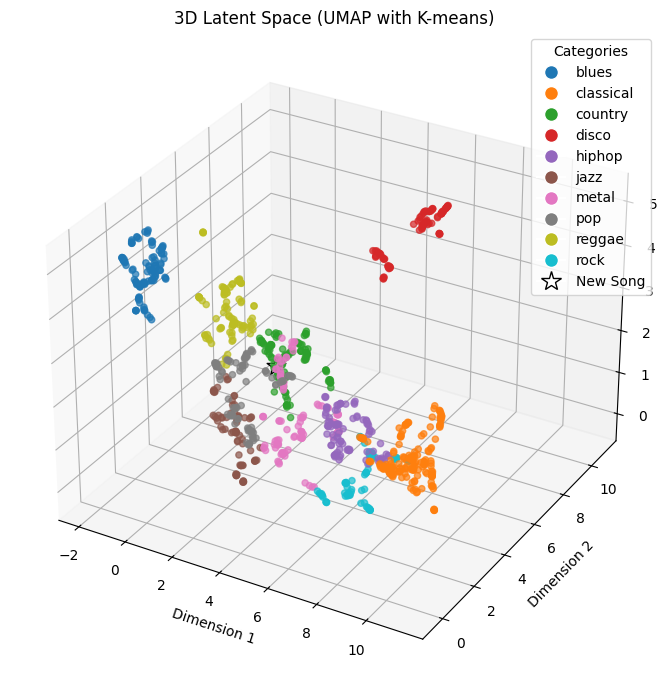


New Song Analysis:
Assigned Genre: pop
Genre Distribution (Top 150 nearest):
  pop: 91
  hiphop: 36
  metal: 22
  country: 1

Features:
  Spectral Centroid: 2114.6448
  Spectral Bandwidth: 2715.1203
  Spectral Rolloff: 4454.4481
  RMS Energy: 0.2732
  Zero Crossing Rate: 0.0382
  MFCC Mean: 3.6186
  MFCC Variance: 3473.1331
  Spectral Contrast: 23.0243
  Harmony Mean: 0.0003
  Harmony Variance: 0.0637
  Percussive Mean: 0.0023
  Percussive Variance: 0.0049
  Tempo: 143.5547 (mean)
  Onset Strength Mean: 1.2198
  Onset Strength Variance: 2.4829
  Mean Beat Interval: 0.4239
  Chromaticity: 0.3070
  Diatonicity: 0.2434
  Dissonance: 0.7705
  Magnitude: 2.2033



In [ ]:
new_song_file = "country.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

___
classical

In [16]:
new_song_file = "classical.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

Error loading classical.mp3: [Errno 2] No such file or directory: 'classical.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.
Error loading classical.mp3: [Errno 2] No such file or directory: 'classical.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.


___
hiphop

In [17]:
new_song_file = "hiphop.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

Error loading hiphop.mp3: [Errno 2] No such file or directory: 'hiphop.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.
Error loading hiphop.mp3: [Errno 2] No such file or directory: 'hiphop.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.


___
disco

In [18]:
new_song_file = "disco.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

Error loading disco.mp3: [Errno 2] No such file or directory: 'disco.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.
Error loading disco.mp3: [Errno 2] No such file or directory: 'disco.mp3'
Error extracting features: y or onset_envelope must be provided
Failed to extract features from the new song.


---
As we can see, there is not a one-size-fits all solution. Surprisingly, the pre-clustering approach, although led to a latent space with lower silhouette, it performed remarkably well:

| Real Genre | Supervised UMAP | Pre-clustered UMAP |
|------------|-----------------|---------------------|
| **Metal**  | Jazz            | **Metal**           |
| **Country**| **Country**     | Pop                 |
|**Classical**| Country        | **Classical**       |
| **Hip-hop**| Jazz            | **Hip-hop**         |
| **Disco**  | **Disco**       | Reggae              |

___

The pre-clustered UMAP approach seems to perform slightly better, correctly classifying 3 out of 5 genres, while the supervised UMAP correctly classifies 2 out of 5.

**Interpretation**

- **Metal**: Correctly identified by pre-clustered UMAP, but misclassified as Jazz by supervised UMAP. This could be due to some shared characteristics between metal and jazz, such as complex rhythms.

- **Country**: Correctly identified by supervised UMAP, but misclassified as Pop by pre-clustered UMAP. This might be due to the blurry lines between these genres, and since this apporach overlaps boudaries, it may be skewed to the side of Pop.

- **Classical**: Correctly identified by pre-clustered UMAP, but misclassified as Country by supervised UMAP. This weird phenomenon might be due to certain features (e.g., string instruments) being overemphasized in the supervised model.

- **Hip-hop**: Correctly identified by pre-clustered UMAP, but misclassified as Jazz by supervised UMAP. This could be due to shared characteristics like syncopated rhythms and the use of samples.

- **Disco**: Correctly identified by supervised UMAP, but misclassified as Reggae by pre-clustered UMAP. This might be due to similarities in rhythm and bass-heavy production between these genres.


**Insights**:

- The supervised UMAP seems to have a bias towards Jazz. This could indicate that the supervised model is overfitting to certain features common in Jazz music.

- The pre-clustered UMAP appears to be more accurate overall, but still struggles with some genres. Its misclassifications (Country as Pop, Disco as Reggae) are between genres that often share some musical characteristics.


## Feature Analysis
Further analysis was conducted to better understand the significance of each feature when it comes to defining the genre of a new music sample. Two methods were used for this:

- Calculating feature importance by genre based on the dataset using median and variance.
- Analyzing feature distribution by genre using boxplots.

### Creating Dataframe

In [ ]:
if os.path.exists("musical_features.csv"):
  final_df = pd.read_csv('musical_features.csv')
  final_df.set_index('File Name', inplace=True)
  final_df.fillna(0, inplace=True)
  final_df["Tempo"] = final_df["Tempo"].apply(lambda x: float(x.strip('[]')))
final_df

### Boxplot Analysis
Below are the boxplots that show the distribution of each feature separated by genre.

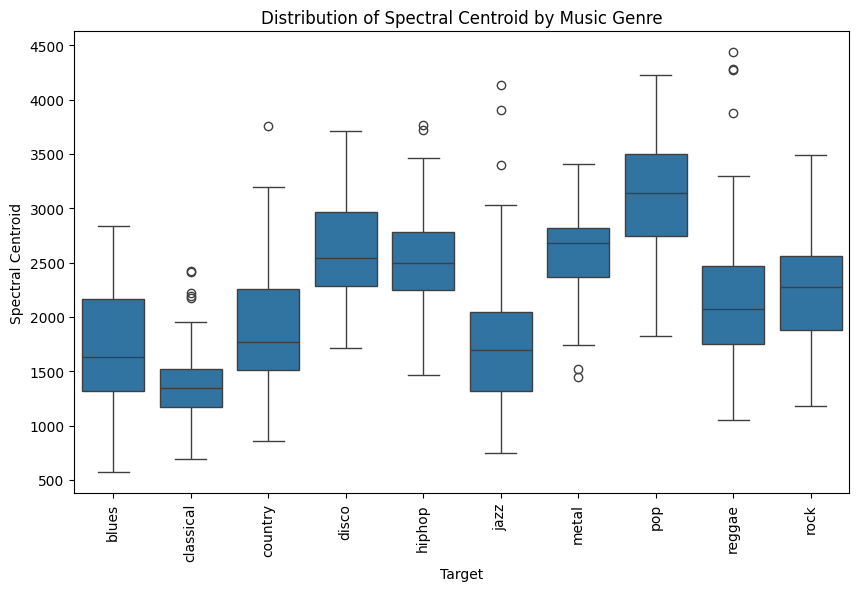

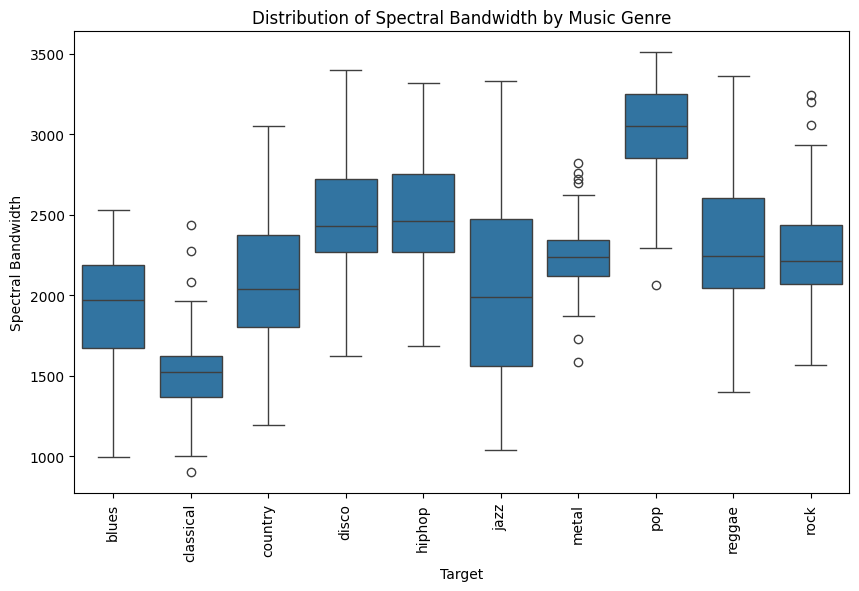

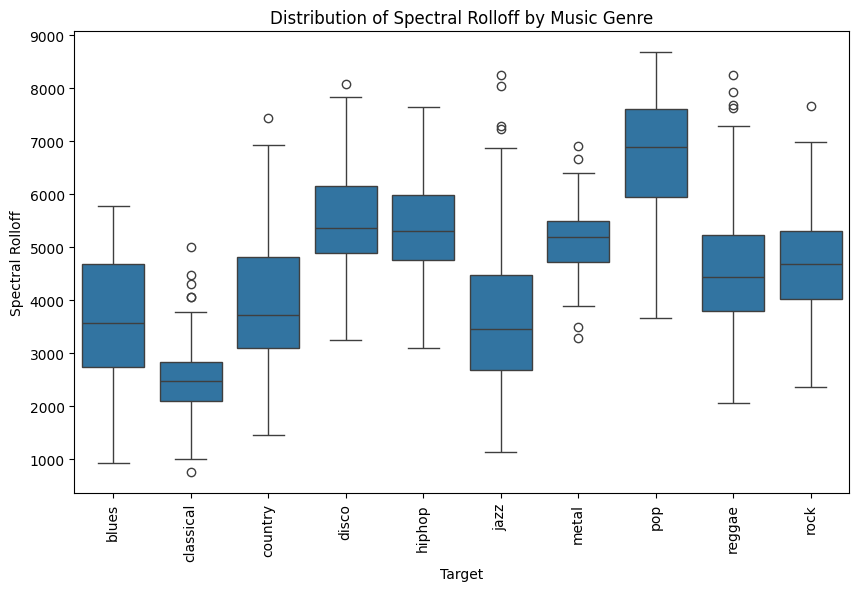

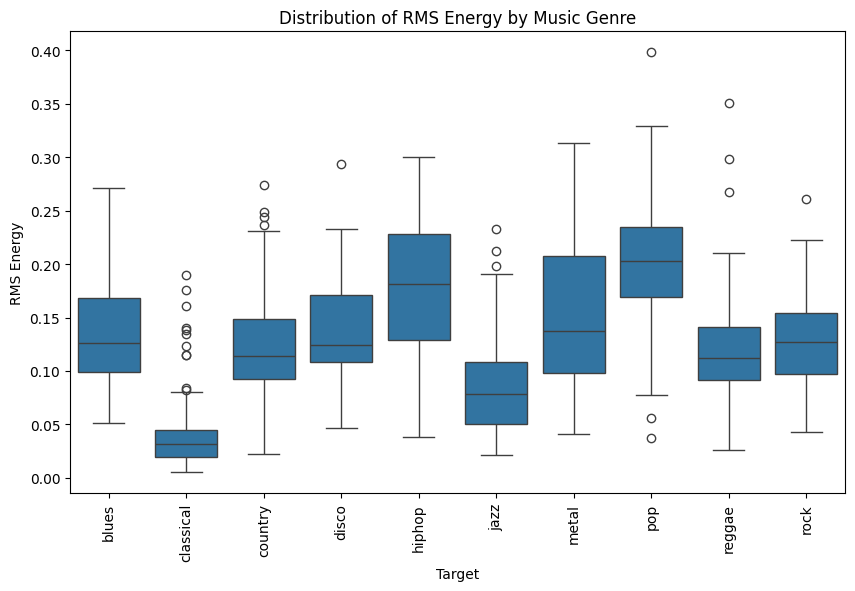

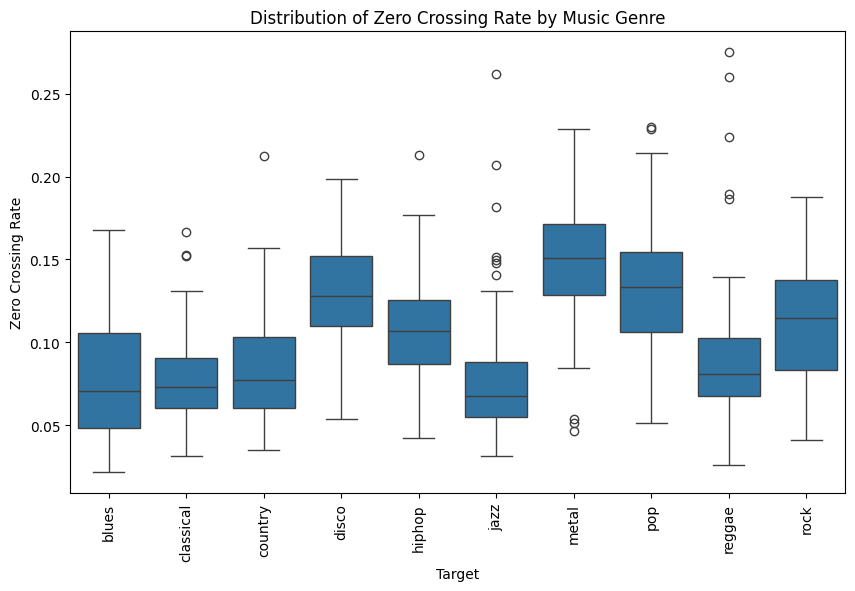

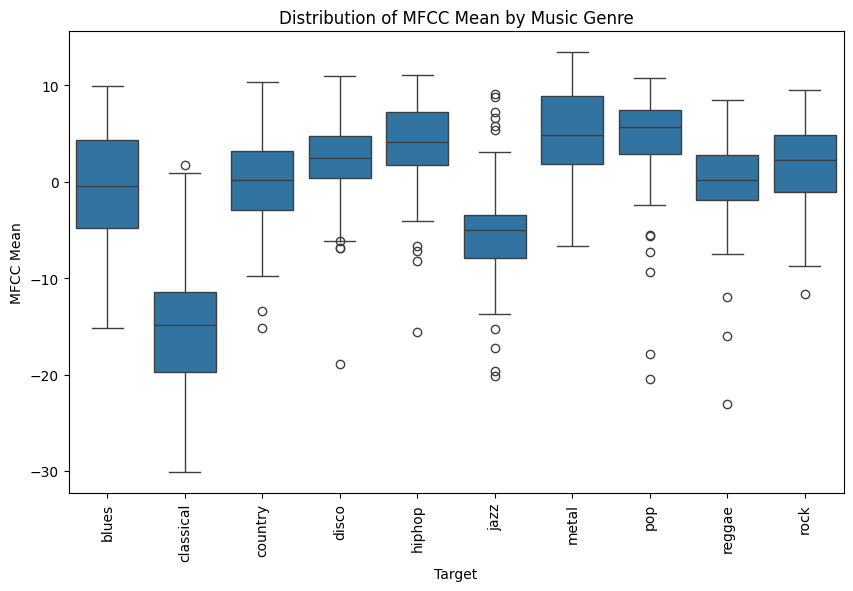

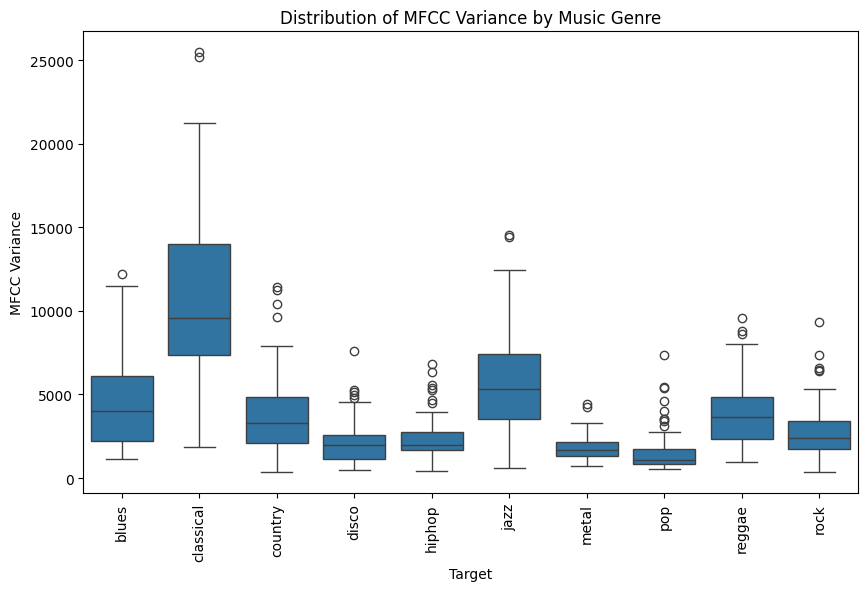

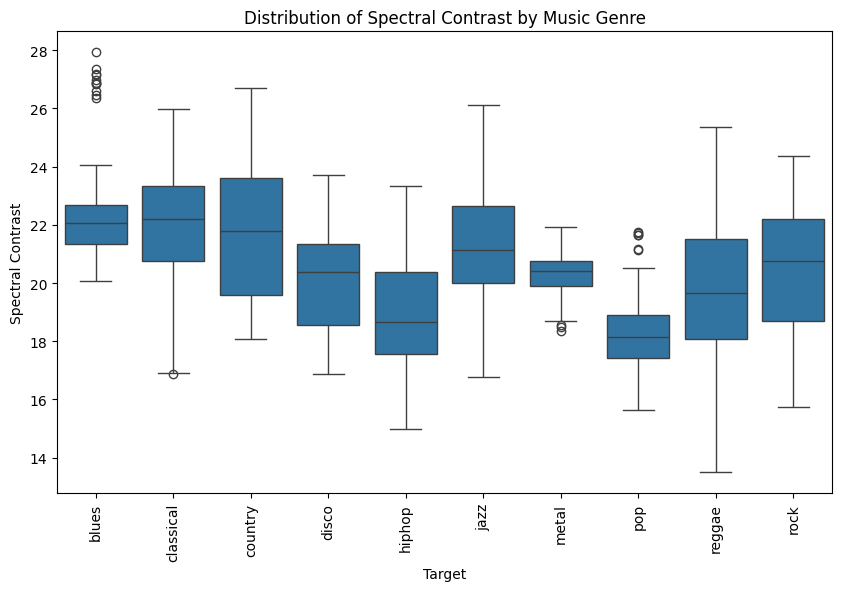

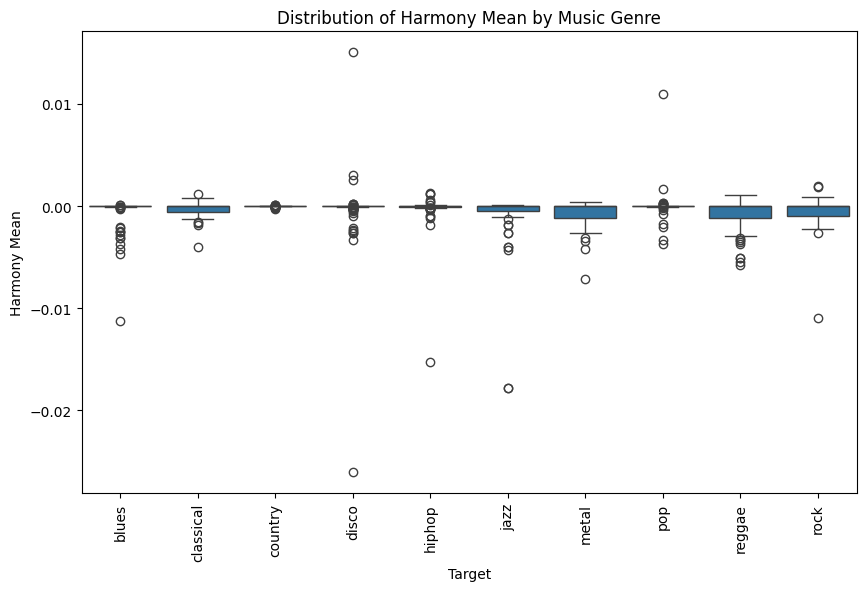

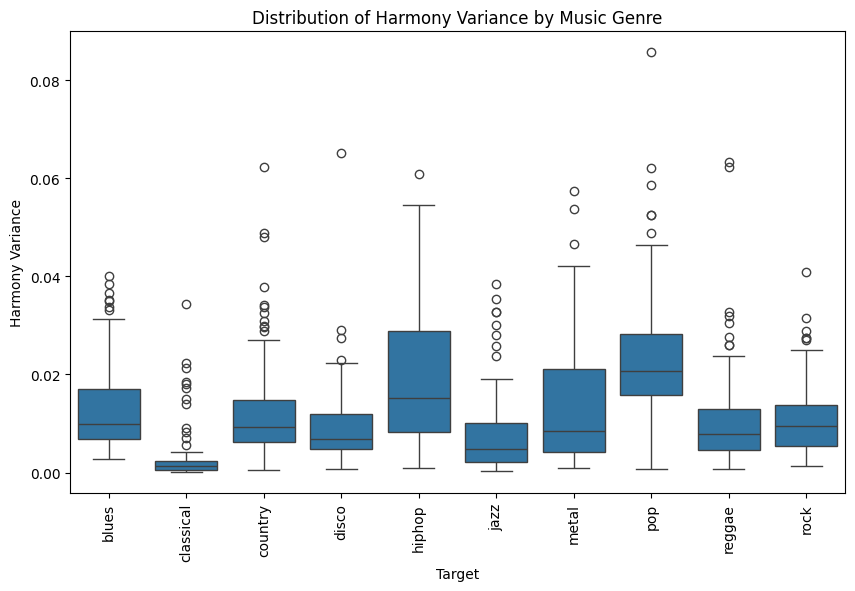

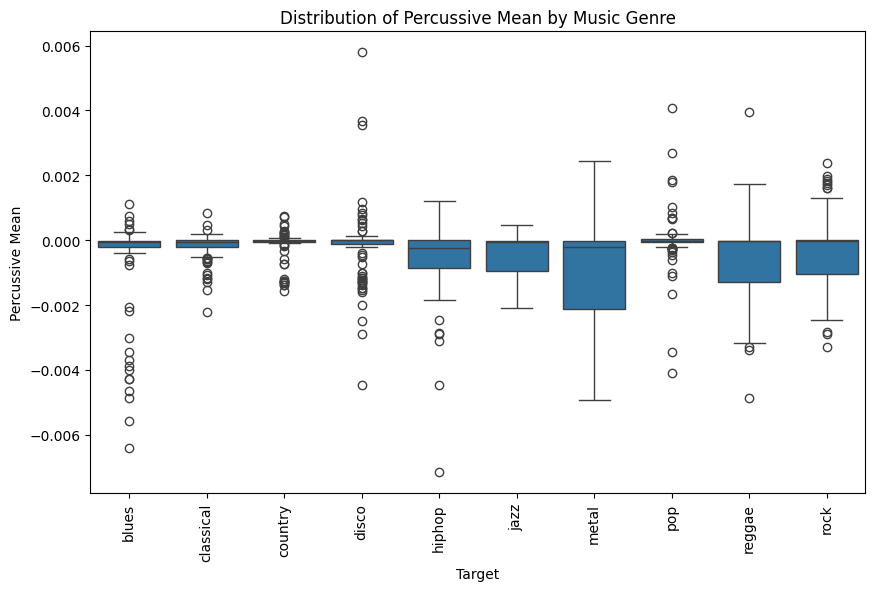

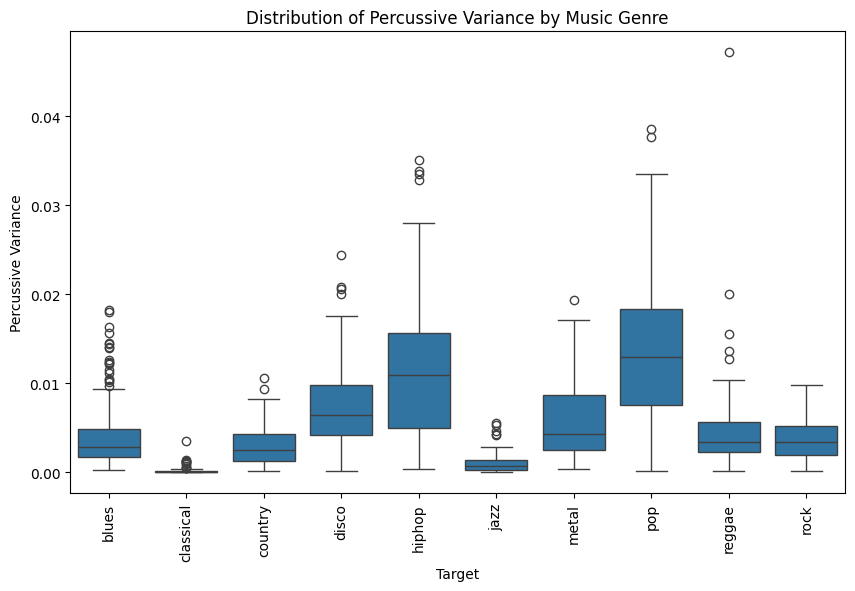

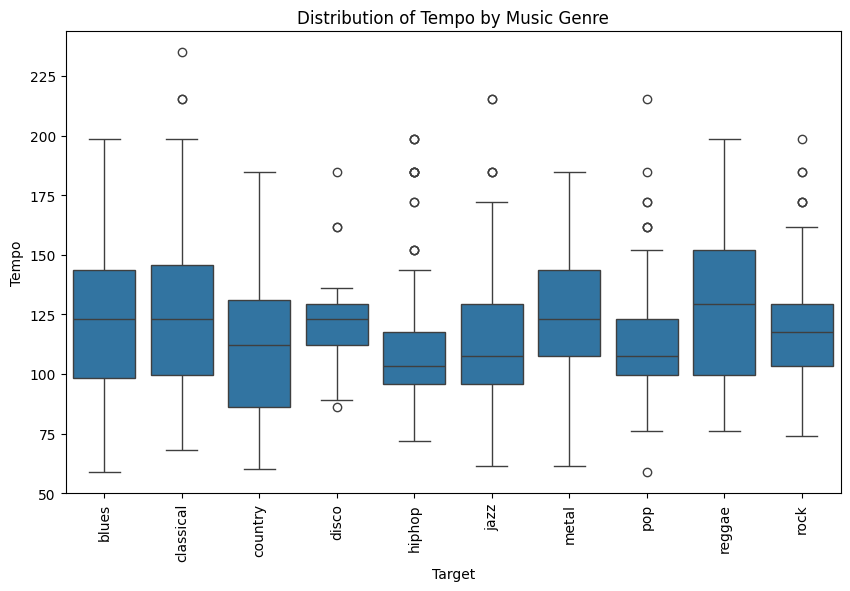

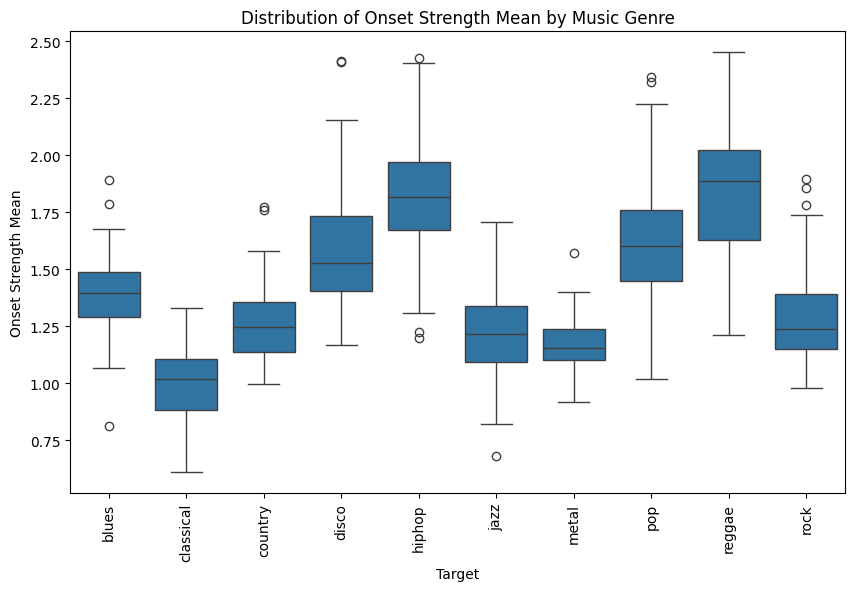

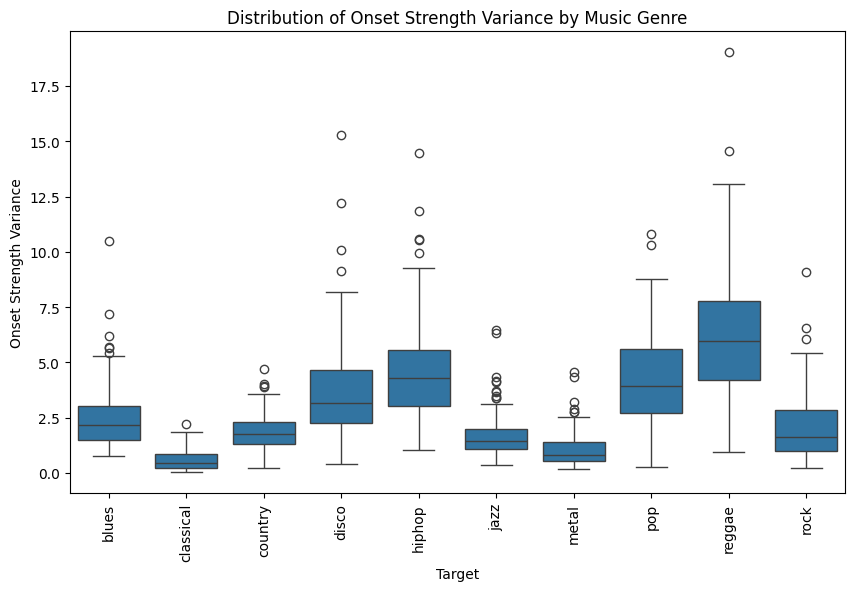

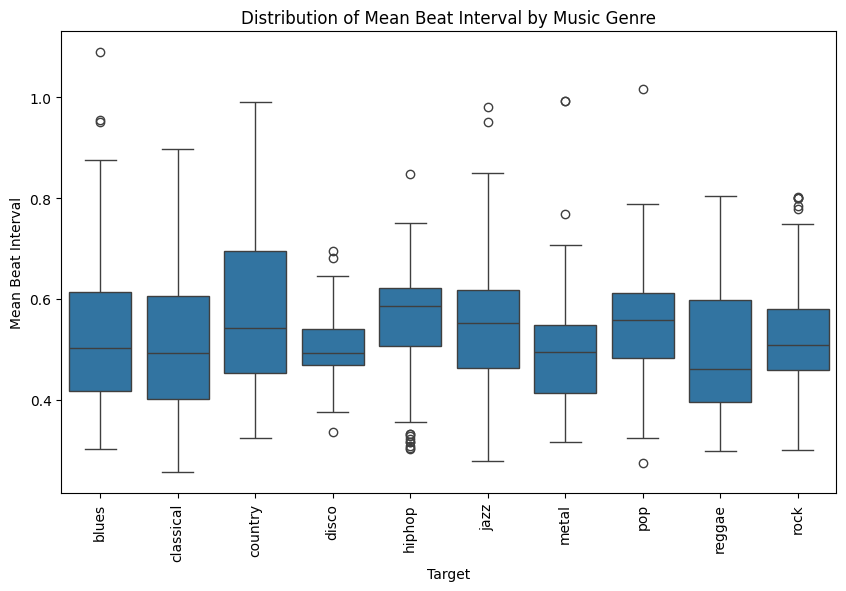

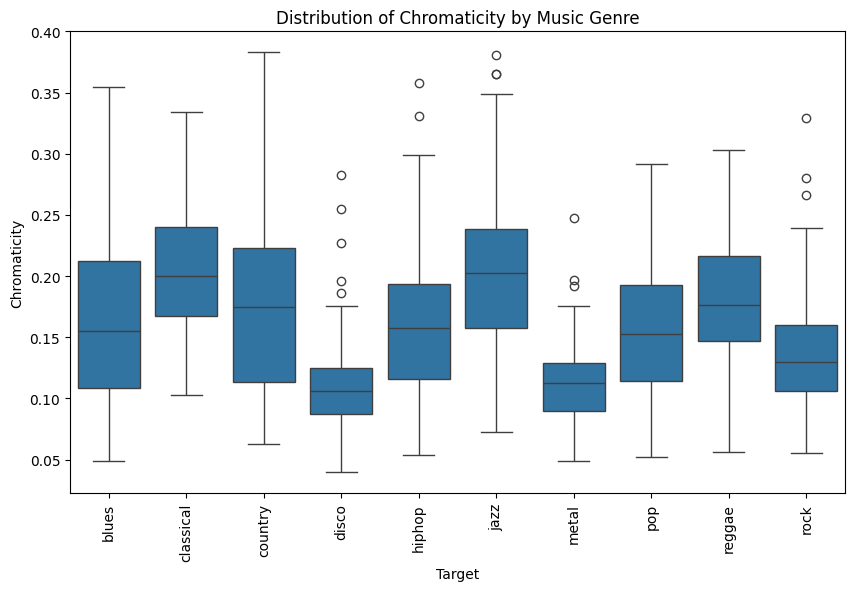

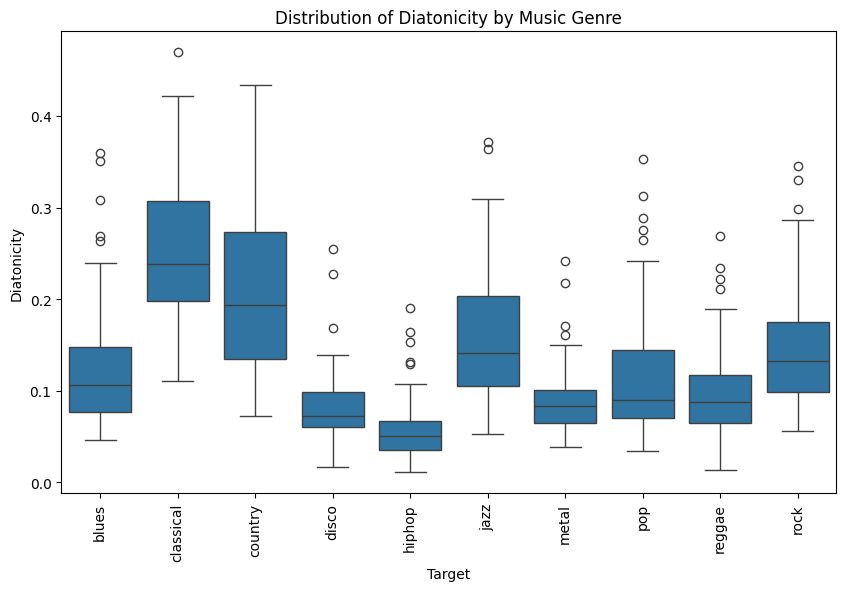

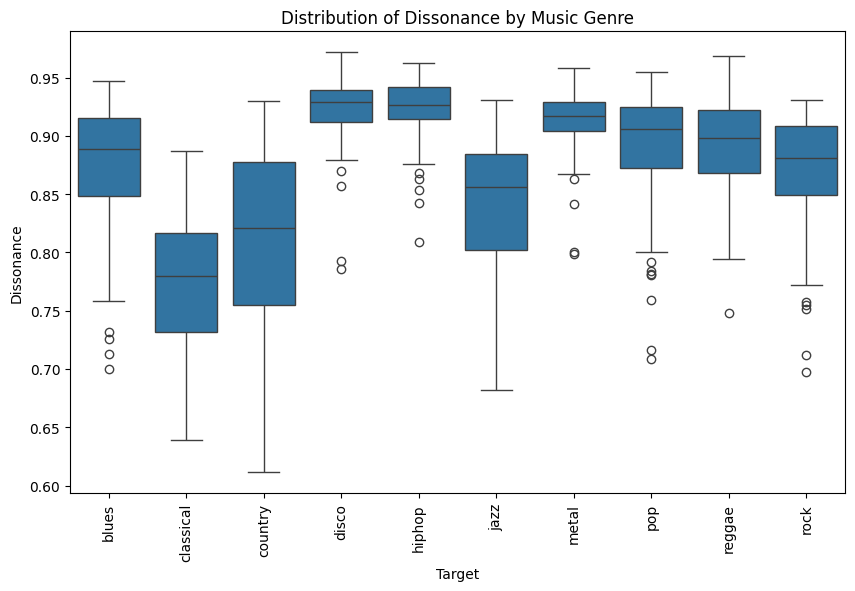

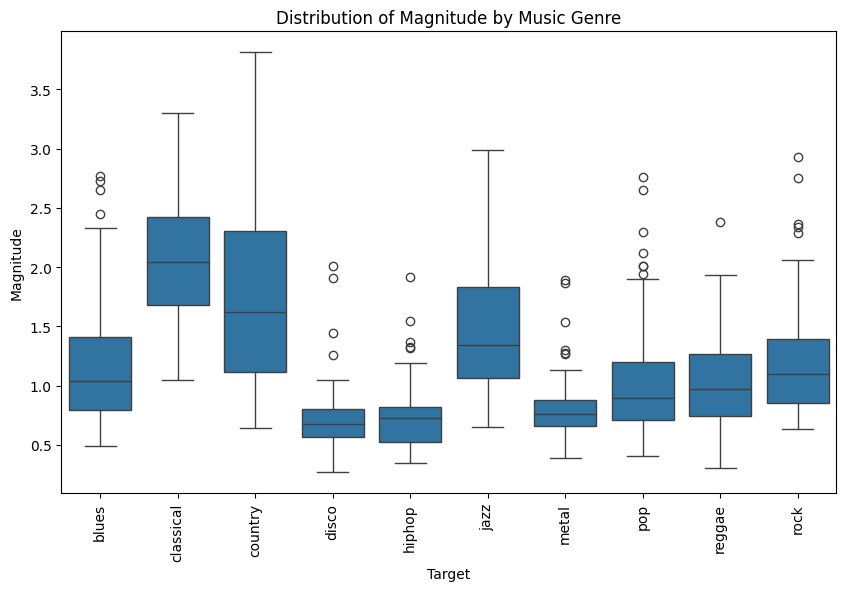

Target                         blues    classical      country        disco  \
Spectral Centroid count   100.000000   100.000000   100.000000   100.000000   
                  mean   1727.667456  1354.120412  1896.191226  2620.061959   
                  std     515.496007   348.227011   575.778973   478.727182   
                  min     570.150688   690.354003   857.996138  1710.844205   
                  25%    1317.055297  1171.418927  1508.356611  2289.268764   
...                              ...          ...          ...          ...   
Magnitude         min       0.485475     1.049713     0.639501     0.266994   
                  25%       0.793671     1.680594     1.116617     0.561267   
                  50%       1.041829     2.040405     1.623102     0.675865   
                  75%       1.412065     2.426439     2.305297     0.797550   
                  max       2.764754     3.296225     3.812381     2.008873   

Target                        hiphop         jazz  

In [25]:
import seaborn as sns

target = 'Target'  # Replace with the actual column name for genre

for feature in final_df.columns:
    if feature != target:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target, y=feature, data=final_df)
        plt.title(f'Distribution of {feature} by Music Genre')
        plt.xticks(rotation=90)
        plt.show()

summary_stats = final_df.groupby(target).describe().transpose()
print(summary_stats)

### Calculating Feature Importance
To calculate feature importance, the median and variance of all features for each genre was calculated. Then, using those values, the coeficient of variation (CV) was calculated and features were ranked by CV for each genre.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
if os.path.exists("musical_features.csv"):
    final_df = pd.read_csv('musical_features.csv')
    final_df.set_index('File Name', inplace=True)
    final_df.fillna(0, inplace=True)
    final_df["Tempo"] = final_df["Tempo"].apply(lambda x: float(x.strip('[]')))

# Calculate the mean and standard deviation of each feature for each genre
mean_stats = final_df.groupby('Target').mean()
std_stats = final_df.groupby('Target').std()

# Compute the coefficient of variation (CV) for each feature
cv_stats = std_stats / mean_stats

# Rank the features for each genre based on their CV (low CV is better)
feature_importance = {}
for genre in mean_stats.index:
    importance = {}
    for feature in mean_stats.columns:
        importance[feature] = cv_stats.loc[genre, feature]
    feature_importance[genre] = sorted(importance.items(), key=lambda x: x[1])[:3]

# Print the top 3 most important features for each genre
for genre, features in feature_importance.items():
    print(f"Top 3 features for {genre}:")
    for feature, score in features:
        print(f"  {feature}: {score}")

NameError: name 'os' is not defined

## Conclusions
Based on the two methods described above, the top 3 most significant features for music genre classification by genre are as described below:

### Blues
- **Percussive Variance:** Presents values between 0 and 0.01, havingg low variance (CV = 0.97%).
- **Harmony Variance:**
- **Onset Strength Variance:** 0.59
Top 3 features for classical:
  Percussive Variance: 2.189255546025624
  Harmony Variance: 1.8053553576582586
  RMS Energy: 0.8600656443777459
Top 3 features for country:
  MFCC Mean: 35.16442058939382
  Harmony Variance: 0.8363908582567527
  Percussive Variance: 0.7443491252383926
Top 3 features for disco:
  MFCC Mean: 2.011806297502695
  Harmony Variance: 0.862076031533365
  Onset Strength Variance: 0.6257433085313207
Top 3 features for hiphop:
  MFCC Mean: 1.1450503070957005
  Harmony Variance: 0.7278345617970896
  Percussive Variance: 0.6905174145634855
Top 3 features for jazz:
  Percussive Variance: 1.114545006881529
  Harmony Variance: 1.0455795560850003
  Onset Strength Variance: 0.6345769792348563
Top 3 features for metal:
  Harmony Variance: 0.8954038871856487
  MFCC Mean: 0.8184550195357967
  Onset Strength Variance: 0.7416566360073166
Top 3 features for pop:
  Harmony Mean: 90.93294844587955
  MFCC Mean: 1.174639409890366
  MFCC Variance: 0.7436867263742993
Top 3 features for reggae:
  MFCC Mean: 15.698317157441574
  Percussive Variance: 1.1276463591381343
  Harmony Variance: 0.9393781796605747
Top 3 features for rock:
  MFCC Mean: 2.9531889798332718
  Onset Strength Variance: 0.7223490877910979
  Harmony Variance: 0.6816333500151127